# Exploring stative and active verbs

This notebook explores quantitative methods for determining the inherent situational aspect (stative/active) of Hebrew verbs in a reduced corpus (Genesis - Kings).

The codes applied for the "covarying collexeme analysis", the association plots and the Principal Component Analysis are adapted from Cody Kingham ([github.com/CambridgeSemiticsLab/BH_time_collocations](https://github.com/CambridgeSemiticsLab/BH_time_collocations))

In [1]:
#Dataset path
PATH = 'datasets/'

import collections
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

# data visualizations
import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from IPython.display import display, clear_output
from adjustText import adjust_text

from tf.app import use

In [2]:
A = use('bhsa', hoist=globals(), mod='etcbc/heads/tf')

### Basic functions

In [3]:
def reverse_hb(hb_text):
    return ''.join(reversed(hb_text))

In [4]:
corpus = [book for book in F.otype.s('book') if book < T.nodeFromSection(('Isaiah',))]
sets={'corpus':corpus} # make set for searching

### Delineating the corpus

The corpus under investigation is understood as all constructions in our corpus (Genesis-Kings) that consists of a predicate phrase (including predicates with object suffix) in the *Qal* and with exactly one complement phrase.

**NB:** Phrases with more than complement type, e.g. multiple words with final h (e.g. Genesis 28:14), does only count once.

We first import the dataset of annotations:

In [5]:
data = pd.read_csv(f'{PATH}corpus_analysis_loc_dir.csv')
data = data[['clause','verb','phrase','cmpl_type']]

In [6]:
print(f'Total total number of constructions: {len(data)}')

Total total number of constructions: 5590


Create verb labels:

In [7]:
verb_label = []

for cl in list(data.clause):
    for ph in Locality.d(cl, 'phrase'):
        if F.function.v(ph) in {'Pred','PreO'}:
            for w in Locality.d(ph, 'word'):
                if F.pdp.v(w) == 'verb':
                    lex = F.lex.v(w)
                    heb = F.lex_utf8.v(w)
                    gloss = F.gloss.v(Locality.u(w, 'lex')[0])
                    verb_label.append(f'{lex}#{heb}_{gloss}')
                    
data.insert(3, "verb_label", verb_label)

For convinience, the target constructions are mapped with their full names:

In [8]:
prep_map = {'L': 'L#ל_to',
            '>L': '>L#אל_to',
            '<L': '<L#על_upon',
            'MN': 'MN#מן_from',
            'B': 'B#ב_in',
            'final_h': 'H-#-ה_directional he'}

const_label = [prep_map[c] for c in list(data.cmpl_type)]
data.insert(5, "const_label", const_label)

In [9]:
data.head()

,clause,verb,phrase,verb_label,cmpl_type,const_label
0,427656,>MR[,651855,>MR[#אמר_say,L,L#ל_to
1,427808,>MR[,652310,>MR[#אמר_say,L,L#ל_to
2,427826,>MR[,652355,>MR[#אמר_say,L,L#ל_to
3,427844,>MR[,652408,>MR[#אמר_say,L,L#ל_to
4,427845,CM<[,652412,CM<[#שׁמע_hear,L,L#ל_to


In [11]:
data[data.cmpl_type == 'final_h']

,clause,verb,phrase,verb_label,cmpl_type,const_label
609,449888,<FH[,719291,<FH[#עשׂה_make,final_h,H-#-ה_directional he
625,450509,<LH[,721113,<LH[#עלה_ascend,final_h,H-#-ה_directional he
830,455070,HLK[,735003,HLK[#הלך_walk,final_h,H-#-ה_directional he
884,456659,NPL[,739822,NPL[#נפל_fall,final_h,H-#-ה_directional he
1417,430925,BW>[,661796,BW>[#בוא_come,final_h,H-#-ה_directional he
...,...,...,...,...,...,...
5585,466118,HLK[,767937,HLK[#הלך_walk,final_h,H-#-ה_directional he
5586,466209,BW>[,768172,BW>[#בוא_come,final_h,H-#-ה_directional he
5587,466304,NPL[,768434,NPL[#נפל_fall,final_h,H-#-ה_directional he
5588,466776,CWB[,769864,CWB[#שׁוב_return,final_h,H-#-ה_directional he


Before cleaning the data we need to count the frequency of all constructions and the frequency of all verbs:

In [12]:
verb_query = '''
corpus
 clause
  phrase function=Pred
    word vs=qal pdp=verb lex={}
'''

all_verbs = A.search(verb_query.format('|'.join(list(set(data.verb)))), sets=sets)

  1.77s 18126 results


For the purpose of cleaning the data, only verbs occuring at least five times will be included in the analysis:

In [39]:
verb_counter = collections.Counter(list(data.verb))
verbs = [v for v in verb_counter if verb_counter[v] >= 5]

data1 = data[data.verb.isin(verbs)]
print(f'Number of cases after cleaning: {len(data1)}')

Number of cases after cleaning: 5228


In [40]:
const_dict = collections.Counter(list(data1.const_label))
const_dict

Counter({'L#ל_to': 1170,
         'H-#-ה_directional he': 226,
         '>L#אל_to': 1736,
         'B#ב_in': 1025,
         'MN#מן_from': 625,
         '<L#על_upon': 446})

## Verb collocations

We are now ready for computing the association strength between verbs and the chosen complement constructions

The first step is to extract the results and organize them in a dataframe with the frequencies of each construction (verb + complement construction).

In [15]:
const_counts = pd.crosstab(index=data1.verb_label, columns=data1.const_label)

const_counts.columns = [prep_map[col] if col in prep_map else col for col in const_counts.columns]

In [16]:
const_counts.head()

,<L#על_upon,>L#אל_to,B#ב_in,H-#-ה_directional he,L#ל_to,MN#מן_from
verb_label,,,,,,
"<BD[#עבד_work, serve",0,0,5,0,5,0
<BR[#עבר_pass,10,11,30,12,14,5
<FH[#עשׂה_make,2,0,8,1,165,5
<LH[#עלה_ascend,34,45,17,17,3,26
<MD[#עמד_stand,20,3,24,0,28,4


In [17]:
const_counts.shape

(104, 6)

In [18]:
def getLabel(series):

    return [f"{r[r.index('#')+1:r.index('_')]} {r[r.index('_')+1:]}" for r in list(series.index)]
    
def top20collexs(df):
    for constr in df:
        positive = pd.DataFrame(df[constr][df[constr] > 0].sort_values(ascending=False))
        
        positive.index = getLabel(positive)
        
        print(f'Top 20 collexemes for {constr}')
        display(positive.head(20))
        print('--------------------------------------')

In [19]:
top20collexs(const_counts)

Top 20 collexemes for <L#על_upon


,<L#על_upon
מלך be king,41
עלה ascend,34
נפל fall,34
ישׁב sit,33
נתן give,29
בוא come,24
עמד stand,20
שׂים put,18
קום arise,14
חנה encamp,12


--------------------------------------
Top 20 collexemes for >L#אל_to


,>L#אל_to
אמר say,928
בוא come,269
שׁוב return,62
קרא call,57
שׁמע hear,56
הלך walk,55
עלה ascend,45
שׁלח send,36
יצא go out,32
ירד descend,25


--------------------------------------
Top 20 collexemes for B#ב_in


,B#ב_in
ישׁב sit,129
הלך walk,83
חנה encamp,64
שׁמע hear,62
בוא come,57
מלך be king,35
נגע touch,32
עבר pass,30
חרה be hot,30
תקע blow,27


--------------------------------------
Top 20 collexemes for H-#-ה_directional he


,H-#-ה_directional he
בוא come,70
הלך walk,31
נוס flee,18
ירד descend,17
עלה ascend,17
שׁוב return,14
יצא go out,13
נפל fall,12
עבר pass,12
נסע pull out,4


--------------------------------------
Top 20 collexemes for L#ל_to


,L#ל_to
אמר say,377
עשׂה make,165
נתן give,122
קרא call,74
הלך walk,40
חטא miss,28
עמד stand,28
שׁוב return,23
זבח slaughter,23
בוא come,22


--------------------------------------
Top 20 collexemes for MN#מן_from


,MN#מן_from
יצא go out,114
נסע pull out,66
סור turn aside,51
לקח take,50
בוא come,34
אכל eat,33
שׁוב return,31
עלה ascend,26
ירא fear,25
הלך walk,25


--------------------------------------


### Contingency table

We are now ready to create contingency tables. As Schmid and Küchenhoof (2013) have demonstrated, filling contingency tables depends on highly subjective choices, in particular as regards the filling of cell 4, namely the cell containing the number of all constructions without the target verb and the target construction, because it demands a notion of the corpus and the linguistic relationship between the construction and the corpus. Is the corpus, for example, all possible verbal constructions of the corpus (Genesis - Kings)? Or is it more restricted to qal-verbs in a predicate function? Or is the corpus a more reduced corpus of those verbal sentences that have one complement phrase? Or only those sentences that were extracted for manual inspection (around 4600 clauses)?

We opt for the second option, that is the entire corpus of verbal clauses for which the verb is predicate in qal.

In [20]:
all_clauses = '''
corpus
 clause
'''
all_clauses = len(A.search(all_clauses, sets=sets))

  0.36s 40582 results


In [21]:
def contingency_table(df):
    '''
    This function takes in a table
    of co-occurrence data and returns the 
    data necessary for 2x2 contingency tables
    for all elements.
    '''
    
    #Calculating how often each verb occurs with a complement construction other than the selected. This step takes
    #a few minutes.
    
    if not 'other' in df.columns:
        verb_other = []

        for row in df.iterrows():
            lex = row[0][:row[0].index('#')] #Getting lexeme of verb
            const_sum = sum(row[1])
            all_occ = verb_counter[lex]

            verb_other.append(all_occ-const_sum)

        df.insert(len(df.columns), 'other', verb_other)
    
    if len(df) == len(verbs):
        
        const_other = []
        
        for col in df.columns:
            const_other.append(const_dict[col] - sum(df[col]))
        
        df.loc[len(df)] = const_other

    # pre-process data for contingency tables
    target_obs = df.apply(lambda col: col.sum(), axis=0, result_type='broadcast') # all columns filled with col sums
    colex_obs = df.apply(lambda row: row.sum(), axis=1, result_type='broadcast') # all rows filled with row sums
    total_obs = all_clauses # total observations
    
    #Filling the contingency tables
    a_matrix = df.iloc[0:len(verbs),:-1]
    b_matrix = colex_obs.iloc[0:len(verbs),:-1].sub(a_matrix)
    c_matrix = target_obs.iloc[0:len(verbs),:-1].sub(a_matrix)
    d_matrix = pd.DataFrame.copy(df, deep=True)
    d_matrix[:] = total_obs # fill all cells with same number: the sum of all values in df
    d_matrix = d_matrix.iloc[0:len(verbs),:-1].sub(a_matrix+b_matrix+c_matrix)

    return {'a':a_matrix, 'b':b_matrix, 'c':c_matrix, 'd':d_matrix}
    
cont_table = contingency_table(const_counts)

In [22]:
cont_table

{'a':                           <L#על_upon  >L#אל_to  B#ב_in  H-#-ה_directional he  \
 verb_label                                                                     
 <BD[#עבד_work, serve               0         0       5                     0   
 <BR[#עבר_pass                     10        11      30                    12   
 <FH[#עשׂה_make                     2         0       8                     1   
 <LH[#עלה_ascend                   34        45      17                    17   
 <MD[#עמד_stand                    20         3      24                     0   
 ...                              ...       ...     ...                   ...   
 YLX[#צלח_be strong                 6         2       0                     0   
 YRR[#צרר_wrap, be narrow           0         0       0                     0   
 YWR[#צור_bind                      9         2       0                     0   
 Z<Q[#זעק_cry                       0        11       1                     0   
 ZBX[#זבח_slaughter    

In [23]:
def apply_Attraction_Reliance(df, con):
    
    df = df.iloc[0:len(verbs),]
    
    b_matrix, c_matrix, d_matrix = [con[x] for x in ('b', 'c', 'd')]
    
    statistics = collections.defaultdict(lambda: collections.defaultdict())    
    for target in df.columns[:-1]:
        for colex in df.index: 
            # values for contingency table and expected freq.
            a = df[target][colex]
            b = b_matrix[target][colex]
            c = c_matrix[target][colex]
            d = d_matrix[target][colex]
            
            #1. Attraction and Reliance
            Attraction = (a*100)/(a+c)
            Reliance = (a*100)/(a+b)
            
            #2. Delta P-scores
            DeltaP_attraction = (a/(a+c))-(b/(b+d))
            DeltaP_reliance = (a/(a+b))-(c/(c+d))
            
            #3. Odds ratio and Fisher's Exact
            contingency = np.matrix([[a, b], [c, d]])
            oddsratio, p_value = stats.fisher_exact(contingency)
            
            statistics[target][colex] = a, a+b, p_value, Attraction, Reliance, DeltaP_attraction, DeltaP_reliance, oddsratio
    
    return statistics

In [69]:
def displayTable(dic, rows=int(), sort_by = 'ΔP Reliance', export=False):
    
    for target in dic:
        
        df = pd.DataFrame(dic[target]).T
        df.columns= ['freq. in pattern','freq. in corpus','Fisher-Yates Exact','Attraction (%)','Reliance (%)',
                     'ΔP Attraction','ΔP Reliance','Odds Ratio']
        df = df.sort_values(by=sort_by, ascending=False)
        
        #Formatting columns
        df['freq. in pattern'] = df['freq. in pattern'].astype(int)
        df['freq. in corpus'] = df['freq. in corpus'].astype(int)
        df['Fisher-Yates Exact'] = [format(v, '.3e') for v in list(df['Fisher-Yates Exact'])]
        df['Attraction (%)'] = df['Attraction (%)'].round(2)
        df['Reliance (%)'] = df['Reliance (%)'].round(2)
        df['Odds Ratio'] = [round(v, 2) for v in list(df['Odds Ratio'])]
        
        #Formatting verb label
        df.index = [f'{l[l.index("#")+1:l.index("_")]} {l[l.index("_")+1:]}' for l in list(df.index)]
                    
        if export:
            df.to_csv(f'collostructional_analysis/{target[target.index("#"):]}.csv')
        
        print(f'\nVerbs attracted to the {target} construction')
        if rows:
            display(df[:rows].round(4))
        else:
            display(df.round(4))
    
displayTable(apply_Attraction_Reliance(const_counts, cont_table), rows=10, sort_by='ΔP Attraction', export=False)


Verbs attracted to the <L#על_upon construction


,freq. in pattern,freq. in corpus,Fisher-Yates Exact,Attraction (%),Reliance (%),ΔP Attraction,ΔP Reliance,Odds Ratio
מלך be king,41,77,6.022e-60,9.19,53.25,0.0910,0.5225,112.76
נפל fall,34,75,1.156e-46,7.62,45.33,0.0752,0.4432,80.70
עלה ascend,34,142,1.630e-35,7.62,23.94,0.0735,0.2292,30.59
ישׁב sit,33,172,4.354e-31,7.40,19.19,0.0705,0.1816,22.99
נתן give,29,172,9.230e-26,6.50,16.86,0.0615,0.1583,19.45
עמד stand,20,79,6.312e-22,4.48,25.32,0.0434,0.2426,31.89
בוא come,24,476,8.998e-10,5.38,5.04,0.0425,0.0399,4.99
שׂים put,18,38,1.065e-25,4.04,47.37,0.0399,0.4631,84.36
קום arise,14,50,2.002e-16,3.14,28.00,0.0305,0.2693,36.10
חנה encamp,12,86,1.967e-10,2.69,13.95,0.0251,0.1288,14.97



Verbs attracted to the >L#אל_to construction


,freq. in pattern,freq. in corpus,Fisher-Yates Exact,Attraction (%),Reliance (%),ΔP Attraction,ΔP Reliance,Odds Ratio
אמר say,928,1313,0.000e+00,53.46,70.68,0.5247,0.6862,114.74
בוא come,269,476,2.701e-241,15.50,56.51,0.1496,0.5285,34.23
שׁוב return,62,140,7.036e-47,3.57,44.29,0.0337,0.4015,18.41
קרא call,57,148,4.149e-39,3.28,38.51,0.0305,0.3436,14.46
שׁמע hear,56,142,4.130e-39,3.23,39.44,0.0300,0.3528,15.02
הלך walk,55,242,1.235e-24,3.17,22.73,0.0269,0.1856,6.76
עלה ascend,45,142,6.022e-27,2.59,31.69,0.0234,0.2751,10.63
שׁלח send,36,45,2.273e-41,2.07,80.00,0.0205,0.7581,91.38
יצא go out,32,193,5.138e-11,1.84,16.58,0.0143,0.1236,4.51
קרב approach,24,32,9.142e-27,1.38,75.00,0.0136,0.7078,68.06



Verbs attracted to the B#ב_in construction


,freq. in pattern,freq. in corpus,Fisher-Yates Exact,Attraction (%),Reliance (%),ΔP Attraction,ΔP Reliance,Odds Ratio
ישׁב sit,129,172,6.009e-170,12.59,75.00,0.1248,0.7278,132.30
הלך walk,83,242,4.510e-70,8.10,34.30,0.0770,0.3196,21.83
חנה encamp,64,86,8.063e-84,6.24,74.42,0.0619,0.7205,119.68
שׁמע hear,62,142,2.546e-60,6.05,43.66,0.0585,0.4128,31.77
בוא come,57,476,2.663e-22,5.56,11.97,0.0450,0.0956,5.50
מלך be king,35,77,2.493e-35,3.41,45.45,0.0331,0.4301,33.26
נגע touch,32,35,2.845e-48,3.12,91.43,0.0311,0.8898,424.88
חרה be hot,30,46,5.243e-37,2.93,65.22,0.0289,0.6276,74.51
עבר pass,30,82,4.947e-27,2.93,36.59,0.0280,0.3413,22.91
תקע blow,27,27,5.227e-44,2.63,100.00,0.0263,0.9754,inf



Verbs attracted to the H-#-ה_directional he construction


,freq. in pattern,freq. in corpus,Fisher-Yates Exact,Attraction (%),Reliance (%),ΔP Attraction,ΔP Reliance,Odds Ratio
בוא come,70,476,2.423e-79,30.97,14.71,0.2997,0.1432,44.15
הלך walk,31,242,7.410e-33,13.72,12.81,0.1319,0.1233,30.25
נוס flee,18,49,1.321e-28,7.96,36.73,0.0789,0.3622,112.57
ירד descend,17,84,4.754e-22,7.52,20.24,0.0736,0.1972,48.91
עלה ascend,17,142,5.643e-18,7.52,11.97,0.0721,0.1146,26.18
שׁוב return,14,140,6.447e-14,6.19,10.00,0.0588,0.0948,21.08
יצא go out,13,193,7.939e-11,5.75,6.74,0.0531,0.0621,13.62
נפל fall,12,75,1.272e-14,5.31,16.00,0.0515,0.1547,35.86
עבר pass,12,82,3.899e-14,5.31,14.63,0.0514,0.1411,32.27
נסע pull out,4,71,6.794e-04,1.77,5.63,0.0160,0.0509,10.83



Verbs attracted to the L#ל_to construction


,freq. in pattern,freq. in corpus,Fisher-Yates Exact,Attraction (%),Reliance (%),ΔP Attraction,ΔP Reliance,Odds Ratio
אמר say,377,1313,3.384e-278,32.22,28.71,0.2985,0.2669,19.54
עשׂה make,165,181,1.193e-237,14.10,91.16,0.1406,0.8867,404.25
נתן give,122,172,4.240e-148,10.43,70.93,0.1030,0.6834,91.64
קרא call,74,148,3.404e-73,6.32,50.00,0.0614,0.4729,35.89
הלך walk,40,242,4.444e-19,3.42,16.53,0.0291,0.1373,6.87
חטא miss,28,39,6.778e-35,2.39,71.79,0.0237,0.6898,87.82
עמד stand,28,79,2.541e-23,2.39,35.44,0.0226,0.3262,18.92
זבח slaughter,23,24,7.130e-35,1.97,95.83,0.0196,0.9301,790.28
שׁוב return,23,140,1.618e-11,1.97,16.43,0.0167,0.1359,6.73
ילד bear,16,17,3.411e-24,1.37,94.12,0.0136,0.9127,546.43



Verbs attracted to the MN#מן_from construction


,freq. in pattern,freq. in corpus,Fisher-Yates Exact,Attraction (%),Reliance (%),ΔP Attraction,ΔP Reliance,Odds Ratio
יצא go out,114,193,5.262e-157,18.24,59.07,0.1804,0.5780,112.61
נסע pull out,66,71,8.719e-115,10.56,92.96,0.1055,0.9158,943.41
סור turn aside,51,61,3.648e-83,8.16,83.61,0.0813,0.8219,354.93
לקח take,50,60,2.149e-81,8.00,83.33,0.0797,0.8191,347.37
אכל eat,33,48,5.848e-49,5.28,68.75,0.0524,0.6729,148.43
שׁוב return,31,140,7.380e-27,4.96,22.14,0.0469,0.2067,19.08
בוא come,34,476,1.932e-13,5.44,7.14,0.0433,0.0567,5.14
ירא fear,25,26,7.752e-45,4.00,96.15,0.0400,0.9467,1664.83
עלה ascend,26,142,1.672e-20,4.16,18.31,0.0387,0.1683,14.91
ירד descend,24,84,5.546e-24,3.84,28.57,0.0369,0.2709,26.55


## Principal Component Analysis

In [25]:
measures = apply_Attraction_Reliance(const_counts, cont_table)

In [26]:
def createOR_table(dic, stat_measure):
    
    new_df = pd.DataFrame()
       
    for target in dic:
        
        df = pd.DataFrame(dic[target]).T
        df.columns= ['freq. in pattern','freq. in corpus','p_value Fisher Exact','Attraction','Reliance','DeltaP Attraction',
                     'DeltaP Reliance','Odds Ratio']
        new_df.insert(len(new_df.columns), target, df[stat_measure])
    
    return new_df
    
OR_df = createOR_table(measures, stat_measure = 'DeltaP Reliance')
OR_df.head()

,<L#על_upon,>L#אל_to,B#ב_in,H-#-ה_directional he,L#ל_to,MN#מן_from
"<BD[#עבד_work, serve",-0.010993,-0.042788,0.474860,-0.005570,0.471286,-0.015405
<BR[#עבר_pass,0.111186,0.091554,0.341286,0.141058,0.142188,0.045667
<FH[#עשׂה_make,0.000060,-0.042969,0.019026,-0.000044,0.886727,0.012278
<LH[#עלה_ascend,0.229249,0.275086,0.094792,0.114550,-0.007731,0.168287
<MD[#עמד_stand,0.242647,-0.004812,0.279083,-0.005580,0.326235,0.035301


In [27]:
replace_inf = OR_df.replace([np.inf, -np.inf], np.nan) #Replace inf with NaN
df = replace_inf.dropna(axis=0, how="any")
df

,<L#על_upon,>L#אל_to,B#ב_in,H-#-ה_directional he,L#ל_to,MN#מן_from
"<BD[#עבד_work, serve",-0.010993,-0.042788,0.474860,-0.005570,0.471286,-0.015405
<BR[#עבר_pass,0.111186,0.091554,0.341286,0.141058,0.142188,0.045667
<FH[#עשׂה_make,0.000060,-0.042969,0.019026,-0.000044,0.886727,0.012278
<LH[#עלה_ascend,0.229249,0.275086,0.094792,0.114550,-0.007731,0.168287
<MD[#עמד_stand,0.242647,-0.004812,0.279083,-0.005580,0.326235,0.035301
...,...,...,...,...,...,...
YLX[#צלח_be strong,0.739156,0.207263,-0.025262,-0.005570,-0.028836,-0.015404
"YRR[#צרר_wrap, be narrow",-0.010993,-0.042788,-0.025264,-0.005570,0.971409,-0.015405
YWR[#צור_bind,0.807411,0.139078,-0.025264,-0.005570,-0.028838,-0.015405
Z<Q[#זעק_cry,-0.010993,0.874148,0.058093,-0.005571,-0.028839,-0.015405


We have four thus far plotted the verbs against four different complement constructions. We can combine the association strength data using Principal Component Analysis (PCA) which is designed to reduce the variation of two or more variables to a low number of dimensions.

In [41]:
#Number of principal components:
pc = 4

In [42]:
pca = PCA(n_components=pc)
principalComponents = pca.fit(df)
pca_transformed = principalComponents.transform(df)

### Explained variance

We can visualize the explained variance by a screeplot. As can be seen below, 92.81% of the variance can be explained by two principal components:

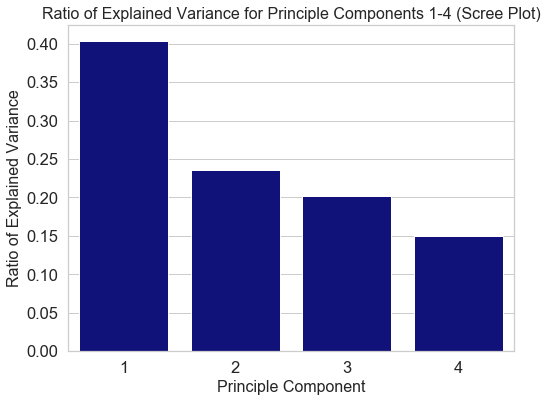

In [43]:
plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(pc)+1, y=principalComponents.explained_variance_ratio_[:pc], color='darkblue')
plt.xlabel('Principle Component', size=16)
plt.ylabel('Ratio of Explained Variance', size=16)
plt.title(f'Ratio of Explained Variance for Principle Components 1-{pc} (Scree Plot)', size=16)
plt.show()

In [57]:
expl_variance = sum(principalComponents.explained_variance_ratio_[:2])
print(f'Explained variance of two first principlec components: {round(expl_variance*100, 2)}%')

Explained variance of two first principlec components: 64.01%


### Individuals

In [45]:
colnames = [f'PC {n}' for n in range(1,pc+1)] #Column names are computed on the basis of number of principal components

pca_ind = pd.DataFrame(pca_transformed, columns = colnames)
pca_ind['lex'] = df.index
pca_ind

,PC 1,PC 2,PC 3,PC 4,lex
0,0.158429,-0.295390,-0.267478,-0.052930,"<BD[#עבד_work, serve"
1,0.035038,-0.022682,-0.021075,0.062745,<BR[#עבר_pass
2,-0.347271,-0.579863,-0.457270,-0.145629,<FH[#עשׂה_make
3,-0.243009,0.117239,0.177729,0.151843,<LH[#עלה_ascend
4,-0.075206,-0.034290,-0.200763,-0.074485,<MD[#עמד_stand
...,...,...,...,...,...
99,-0.454927,0.544156,-0.109272,0.084932,YLX[#צלח_be strong
100,-0.398227,-0.639472,-0.519589,-0.144732,"YRR[#צרר_wrap, be narrow"
101,-0.460703,0.599132,-0.146114,0.015106,YWR[#צור_bind
102,-0.299420,-0.051015,0.269909,0.785213,Z<Q[#זעק_cry


### Variables

In [46]:
pca_var = pd.DataFrame(pca.components_, columns = df.columns).T

pca_var.columns = colnames

### Plotting

In [63]:
def annotation(labels, x, y, zoom, gloss):
    noun_xy = {} # for noun_dict
        
    for i, noun in enumerate(labels):
        
        label = labels[i]
        if '#' in label:
            if gloss:
                label = f'{reverse_hb(label[label.index("#")+1:label.index("_")])} {label[label.index("_")+1:]}'
            else:
                label = label[label.index('_')+1:]
        
        noun_x, noun_y = x[i], y[i]
        if zoom: # to avoid annotating outside of field of view (makes plot small)
            if any([noun_x < zoom[0], noun_x > zoom[1], noun_y < zoom[2], noun_y > zoom[3]]):                
                continue # skip noun      
           
        #Some lexemes share the same gloss. To disambiguate similar glosses (but different lexemes), a number is added. 
        if label in noun_xy:
            n=2
            new_label = f'{label}#{n}'
            while new_label in noun_xy:
                new_label = f'{label}#{n}'
                n+=1
            label = new_label
            
        noun_xy[label] = (noun_x, noun_y) #Adding to dictionary
    
    return noun_xy

def plot_PCA(dim1=1,
             dim2=2,
             zoom=tuple(), 
             save=False, 
             title='', 
             var_anno=True,
             var_components=pd.DataFrame(),
             var_anno_size='18',
             var_gloss=True,
             ind_anno=True,
             ind_components=pd.DataFrame([]),
             ind_anno_size='18',
             ind_gloss=True,
             color=list(),
             ellipsis = False,
             label = False,
             adjust = False
            ):
    '''
    Plots a PCA noun space.
    Function is useful for presenting various zooms on the data.
    '''
    
    #The PC-dimensions are aligned with columns (dimension 1 = column 0, etc.)
    dim1 -= 1
    dim2 -= 1

    # plot coordinates
    f, ax = plt.subplots(1,1,figsize=(15,15))
    ax.grid(False)
    
    if zoom:
        xmin, xmax, ymin, ymax = zoom
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

    if title:
        plt.title(title)
        
    if not var_components.empty:
        plt.xlabel(f'{var_components.columns[dim1]} ({round(principalComponents.explained_variance_ratio_[dim1]*100, 1)}%)')
        plt.ylabel(f'{var_components.columns[dim2]} ({round(principalComponents.explained_variance_ratio_[dim2]*100, 1)}%)')
    else:
        plt.xlabel(f'{ind_components.columns[dim1]} ({round(principalComponents.explained_variance_ratio_[dim1]*100, 1)}%)')
        plt.ylabel(f'{ind_components.columns[dim2]} ({round(principalComponents.explained_variance_ratio_[dim2]*100, 1)}%)') 
    
    plt.axhline(color='red', linestyle=':')
    plt.axvline(color='red', linestyle=':')
    
    annotations = []

    # annotate individuals:
    if not ind_components.empty:
        if list(color):
            plt.scatter(ind_components.iloc[:,dim1], ind_components.iloc[:,dim2], s=50, c=list(color))
            
            '''            #Merging individuals dataframe and vowel-pattern dataframe:
            combined_df = pd.merge(ind_components, color, on='lex', how="left")
            combined_df['color'] = combined_df.iloc[:,-1]
            
            for color in set(combined_df.evaluation):
                df_color = combined_df[combined_df.evaluation == color]
                plt.scatter(df_color.iloc[:,dim1], df_color.iloc[:,dim2], label=color)
            
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles[1:], labels[1:], fontsize=22)'''
            
        else:
            plt.scatter(ind_components.iloc[:,dim1], ind_components.iloc[:,dim2], s=50, c='lightgrey', alpha=.6)
        
        if ind_anno:
            ind_annotate = annotation(ind_components.lex, ind_components.iloc[:,dim1], ind_components.iloc[:,dim2], zoom, ind_gloss)
            for n in ind_annotate:
                annotations.append(plt.text(ind_annotate[n][0], ind_annotate[n][1], n, size=ind_anno_size, color='grey'))
            if adjust:
                adjust_text(annotations)
                
    # annotate variables:
    if not var_components.empty:
        plt.scatter(var_components.iloc[:,dim1], var_components.iloc[:,dim2], s=50, color='darkblue')
        
        if var_anno:
            var_annotate = annotation(var_components.index, var_components.iloc[:,dim1], var_components.iloc[:,dim2], zoom, var_gloss)
            for n in var_annotate:
                annotations.append(plt.text(var_annotate[n][0], var_annotate[n][1], n,  size=var_anno_size, color='darkblue'))

    if ellipsis:
        for e in ellipsis:
            x, y, width, height, angle, text = e[0], e[1], e[2], e[3], e[4], e[5]
            e = Ellipse((x, y), width, height, angle, facecolor='none', ec='darkblue', lw=1)
            plt.annotate(text, (x+width/2,y+height/3), color='darkblue', size=18)
            ax.add_artist(e)
                
    if label:
            x, y, label = l[0], l[1], l[2]
            plt.annotate(label, (x, y), color='darkblue', size=22)
    
    if save:
        plt.savefig(f'images/{save}', dpi=300, bbox_inches='tight')
    
    plt.show()

When we plot the weighted variables of the two first dimensions, we observe that the opposition between "to" and "in" accounts for the biggest variation. In this dataset, the two categories are the prototypical means of expressing location and direction. As can be expected the other categories, "upon" and "final H" are located in between, "final H" closer to "to", and "upon" closer to "in", supporting this axis of directionality.

The variation of the second dimension is much smaller and describes the opposition between primarily "in" and "upon". The reason for this opposition may be that the preposition "upon" can be used for other expressions than just the locative, an issue that might cause variation.

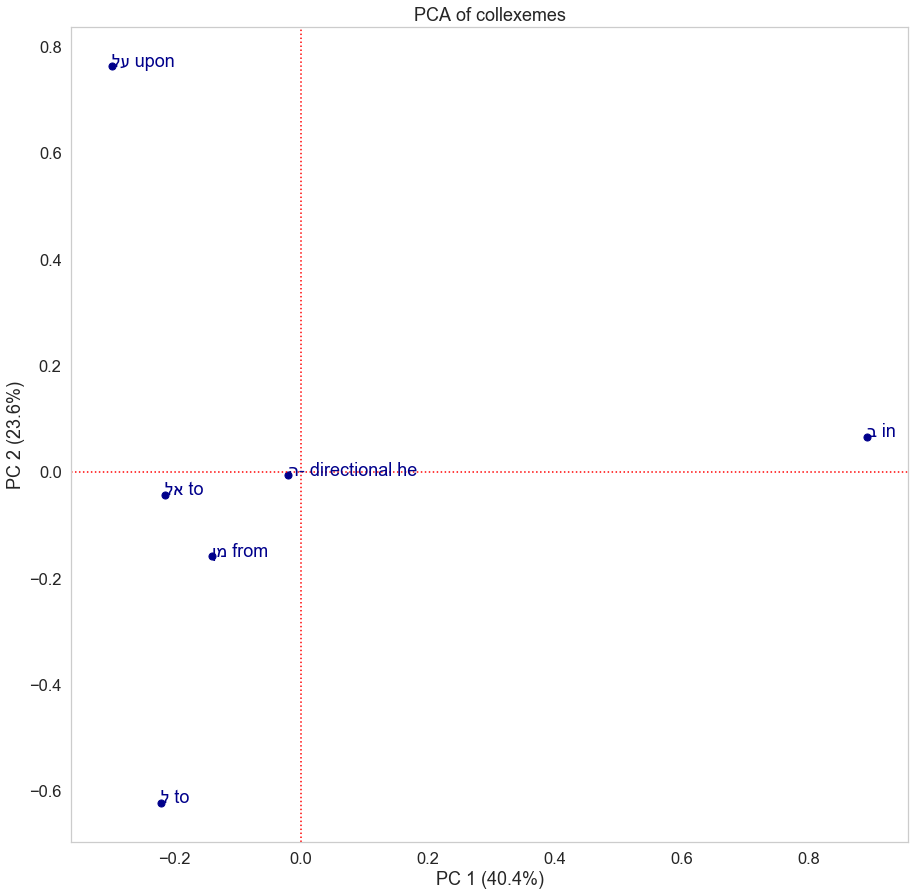

In [53]:
plot_PCA(dim1=1, dim2=2, title='PCA of collexemes', save='PCA_categories', var_components=pca_var, var_gloss=True,
         var_anno_size=18)

We can plot the individual glosses onto this graph to see how they cluster around the categories:

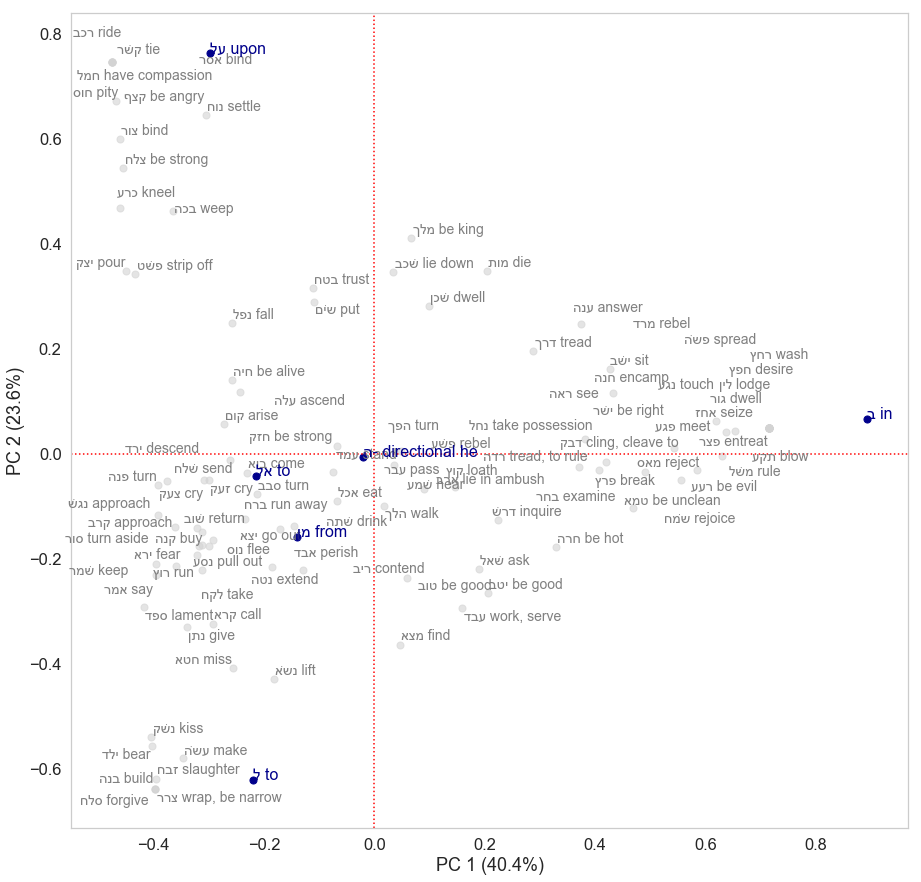

In [65]:
plot_PCA(dim1=1, dim2=2, var_components=pca_var, var_anno_size=16,
        ind_components=pca_ind, ind_anno_size=14, ind_anno=True, ind_gloss=True, adjust=True)

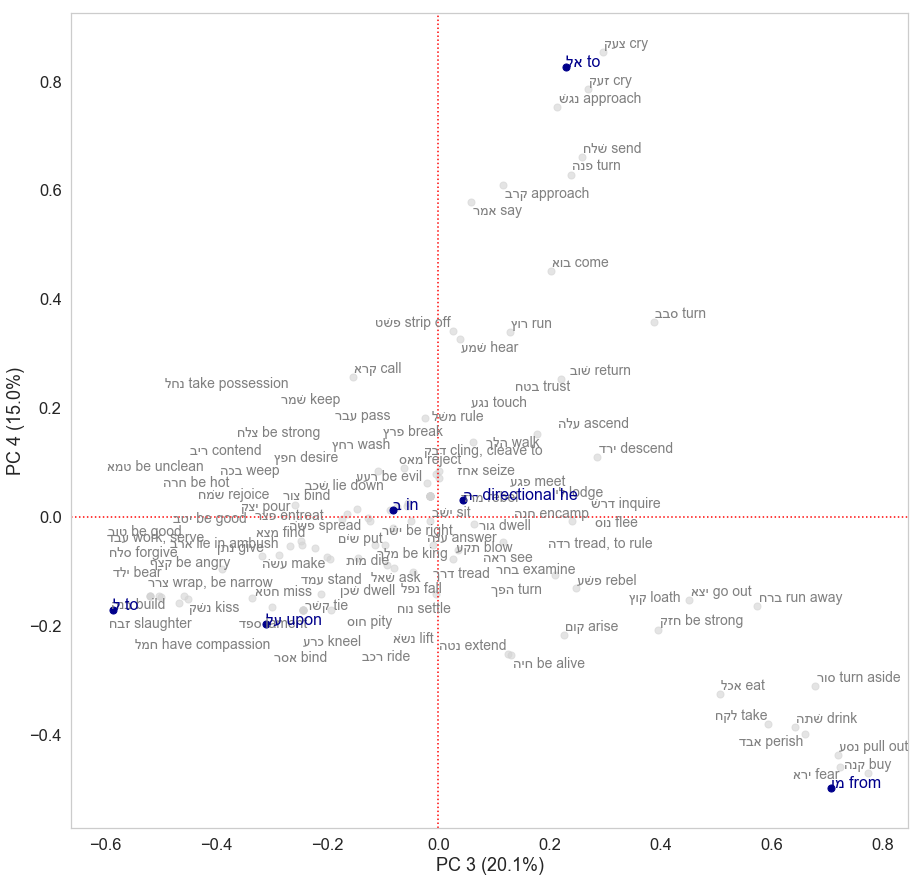

In [66]:
plot_PCA(dim1=3, dim2=4, var_components=pca_var, var_anno_size=16,
        ind_components=pca_ind, ind_anno_size=14, ind_anno=True, ind_gloss=True, adjust=True)

With zoom:

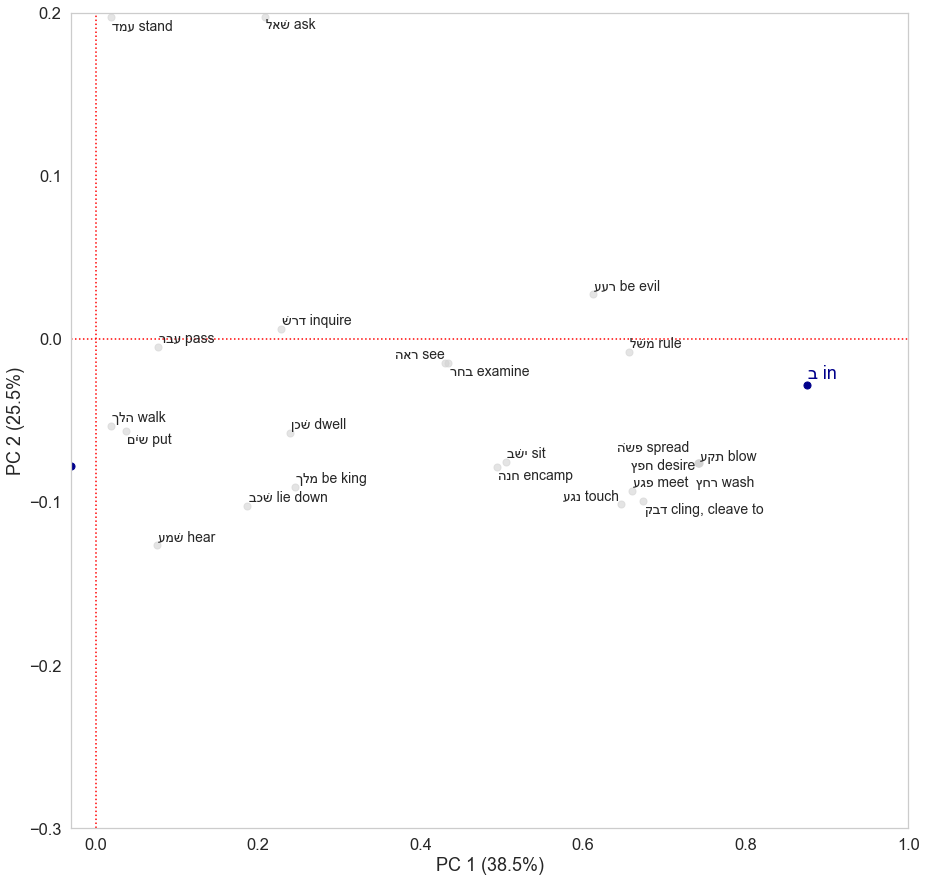

In [66]:
plot_PCA(zoom=(-0.03,1,-0.3,0.2),var_components=pca_var, var_gloss=True,
        ind_components=pca_ind, ind_anno_size=14, ind_anno=True, adjust=True)

## Cluster analysis

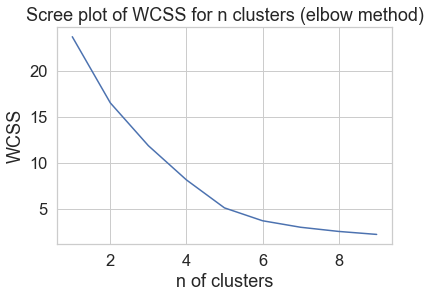

In [105]:
def elbow(X,max_clusters=10):

    wcss = [] #for storing the intertia property

    for i in range(1, max_clusters):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters), wcss)
    plt.title('Scree plot of WCSS for n clusters (elbow method)')
    plt.xlabel('n of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
elbow(df)

In [106]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter=300, n_init=10, random_state=0).fit(df)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

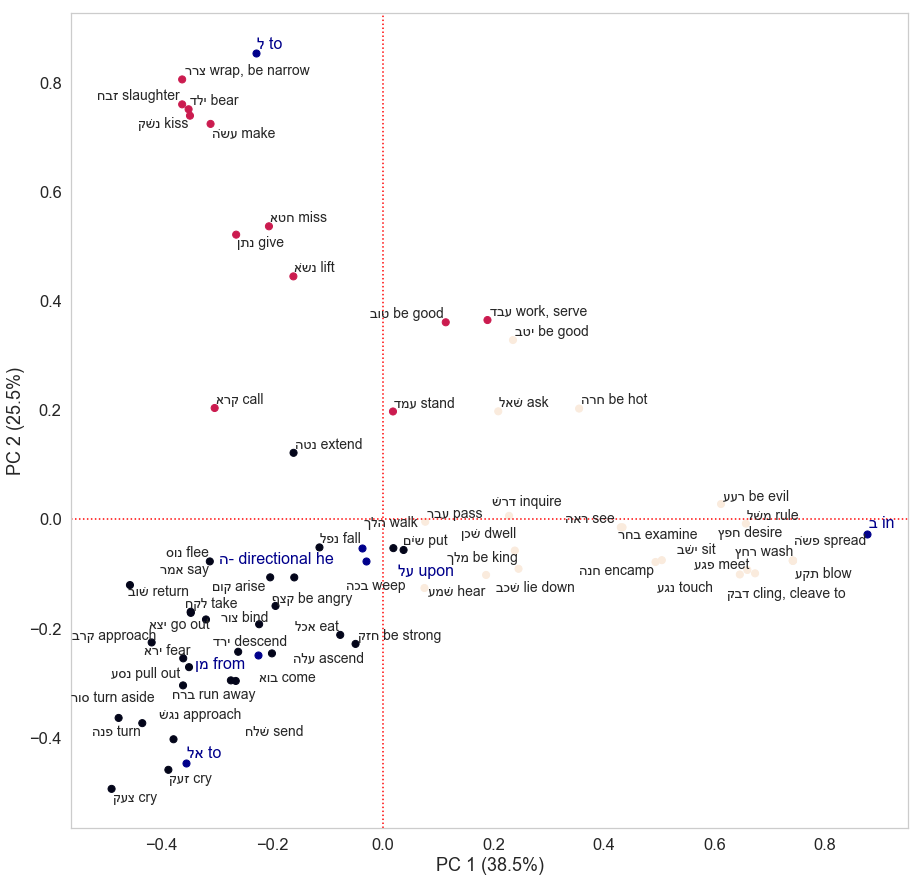

In [107]:
plot_PCA(dim1=1, dim2=2, var_components=pca_var, var_anno_size=16,
        ind_components=pca_ind, ind_anno_size=14, ind_anno=True, ind_gloss=True, adjust=True, color=kmeans.labels_)

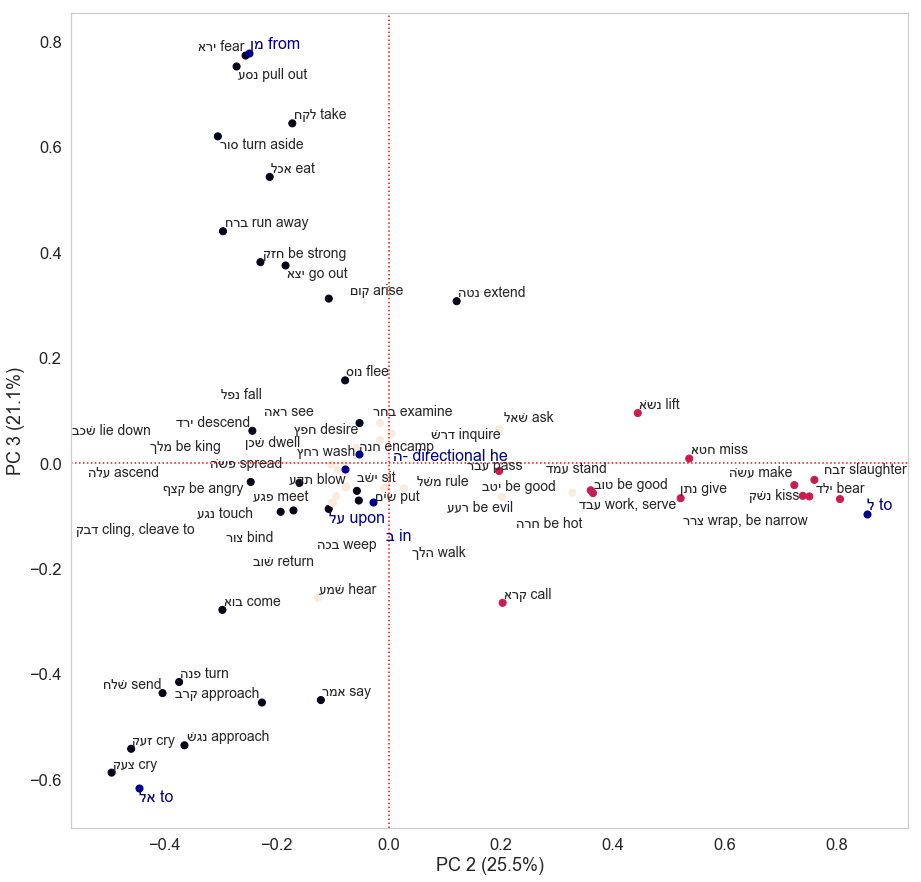

In [146]:
plot_PCA(dim1=2, dim2=3, var_components=pca_var, var_anno_size=16,
        ind_components=pca_ind, ind_anno_size=14, ind_anno=True, ind_gloss=True, adjust=True, color=kmeans.labels_)

## Explore individuals

In [58]:
query = '''
corpus
  clause
  /without/
    phrase function=Objc
  /-/
  /without/
    phrase function=Cmpl
    > phrase function=Cmpl
  /-/
    phrase function=Cmpl
    /with/
      =: word lex=MN
    /-/
    phrase function=Pred
      word vs=qal pdp=verb lex={}
'''

In [52]:
def show(lex, s=1, n=10):
    A.show(A.search(query.format(lex), sets=sets), start=s, end=n)

In [60]:
show('JR>[', s=1, n=32)

  2.01s 25 results


### Export

The first component distinguishes directional from non-directional senses. This variable is therefore exported for evaluation:

In [43]:
data = pca_ind[['lex', 'PC 1']]
data.to_csv(f'{PATH}active_stative_verbs_pca.csv')

## Evaluation

The purpose of this section is to evaluate the results of the PCA in light of whether the position in the grid is expected or unexpected/surprising. Intuitively, a verb like "sit" is expected to be stative and that is confirmed by the PCA. Other verbs are positioned in surprising locations.

To evaluate the results, a simple evaluation scheme is applied. The position of the verb can be either: 

* Expected
* Unknown (?)

In [67]:
data = pd.read_csv(f'{PATH}active_stative_verbs_pca.csv')

In [68]:
data.head()

,Unnamed: 0,lex,PC 1
0,0,"<BD[#עבד_work, serve",0.189412
1,1,<BR[#עבר_pass,0.076852
2,2,<FH[#עשׂה_make,-0.311593
3,3,<LH[#עלה_ascend,-0.200511
4,4,<MD[#עמד_stand,0.018438


If Principal Component 1 is negative, the verb is assumed to be stative, if positive then active. The expected annotation is added to a separate column:

In [69]:
data['Aktionsart'] = np.where(data['PC 1'] > 0, 'stative', 'active')

In [76]:
data.head()

,Unnamed: 0,lex,PC 1,Aktionsart
0,0,"<BD[#עבד_work, serve",0.189412,stative
1,1,<BR[#עבר_pass,0.076852,stative
2,2,<FH[#עשׂה_make,-0.311593,active
3,3,<LH[#עלה_ascend,-0.200511,active
4,4,<MD[#עמד_stand,0.018438,stative


### Evaluating

In [61]:
annotations = 'EXP ?'.split()

STOP = 'stop'
error_message = "Input is invalid"

In [62]:
def input_loop(question, right_answer):
    '''
    input_loop is used when the user is required to make an input. Question has to be a string,
    while right_answer is a list of accepted answer(s).
    '''
    while True:
        test = input(f'{question} ({",".join(right_answer)})') #The user is required to respond to message.
        if test in right_answer:
            return test
        elif test in [STOP]: #Input is accepted
            return test
        else: #Input is wrong and the user has respond again.
            print(error_message)

In [77]:
def user_input(verbs, df=data):
    clear_output()
    answers = {}
    
    for v in verbs:
        
        df_subset = df[df.lex == v]
        lex = df_subset.lex.item()
        Aktionsart = df_subset.Aktionsart.item()

        question = f'Is {lex} {Aktionsart}?'

        user_input = input_loop(question, annotations)

        if user_input == STOP:
            return answers
        else:
            answers[lex] = user_input
    return answers

In [78]:
prev_runs = []

def Verbs(orig_data, prev_runs):

    total_verbs = list(orig_data.lex)
    
    annotated_verbs = []
    remaining_verbs = []
         
    ##1. Check previous runs (dictionaries with annotations)
    for r in prev_runs:
        for verb in r:
            annotated_verbs.append(verb)
            
    ##2. Determine the remaining clauses
    for verb in total_verbs:
        if not verb in annotated_verbs:
            remaining_verbs.append(verb)
    
    return remaining_verbs
        
verbs = Verbs(data,prev_runs)

In [79]:
len(verbs)

62

In [80]:
run1 = user_input(verbs)

Is <BD[#עבד_work, serve stative? (EXP,?)?
Is <BR[#עבר_pass stative? (EXP,?)?
Is <FH[#עשׂה_make active? (EXP,?)EXP
Is <LH[#עלה_ascend active? (EXP,?)EXP
Is <MD[#עמד_stand stative? (EXP,?)EXP
Is >KL[#אכל_eat active? (EXP,?)EXP
Is >MR[#אמר_say active? (EXP,?)EXP
Is BKH[#בכה_weep active? (EXP,?)EXP
Is BRX[#ברח_run away active? (EXP,?)EXP
Is BW>[#בוא_come active? (EXP,?)EXP
Is BXR[#בחר_examine stative? (EXP,?)EXP
Is C>L[#שׁאל_ask stative? (EXP,?)?
Is CKB[#שׁכב_lie down stative? (EXP,?)EXP
Is CKN[#שׁכן_dwell stative? (EXP,?)EXP
Is CLX[#שׁלח_send active? (EXP,?)EXP
Is CM<[#שׁמע_hear stative? (EXP,?)?
Is CWB[#שׁוב_return active? (EXP,?)EXP
Is DBQ[#דבק_cling, cleave to stative? (EXP,?)EXP
Is DRC[#דרשׁ_inquire stative? (EXP,?)?
Is FJM[#שׂים_put stative? (EXP,?)?
Is HLK[#הלך_walk stative? (EXP,?)EXP
Is JCB[#ישׁב_sit stative? (EXP,?)EXP
Is JLD[#ילד_bear active? (EXP,?)EXP
Is JR>[#ירא_fear active? (EXP,?)?
Is JRD[#ירד_descend active? (EXP,?)EXP
Is JVB[#יטב_be good stative? (EXP,?)EXP
Is JY>[#יצא_go

### Export evaluation

#### Merge outputs

In [81]:
outputs = [run1]

combined = pd.DataFrame()

for d in outputs:
    d = pd.DataFrame([d]).T
    combined = combined.append(d)
    
len(combined)

62

In [82]:
combined['lex'] = combined.index

In [83]:
new_df = pd.merge(data, combined, on = 'lex', how='left')
new_df

,Unnamed: 0,lex,PC 1,Aktionsart,0
0,0,"<BD[#עבד_work, serve",0.189412,stative,?
1,1,<BR[#עבר_pass,0.076852,stative,?
2,2,<FH[#עשׂה_make,-0.311593,active,EXP
3,3,<LH[#עלה_ascend,-0.200511,active,EXP
4,4,<MD[#עמד_stand,0.018438,stative,EXP
5,5,>KL[#אכל_eat,-0.077016,active,EXP
6,6,>MR[#אמר_say,-0.457448,active,EXP
7,7,BKH[#בכה_weep,-0.160180,active,EXP
8,8,BRX[#ברח_run away,-0.274835,active,EXP
9,9,BW>[#בוא_come,-0.265959,active,EXP


#### Export to CSV

In [84]:
new_df.to_csv(f'{PATH}active_stative_verbs_pca_evaluated_1.csv')

### Explore difficult/unknown cases

Some cases were difficult to evaluate and I need to explore those further. The cases in question are those marked with '?':

In [36]:
data = pd.read_csv(f'{PATH}active_stative_verbs_pca_evaluated.csv')
data.columns = ['-','-','PC 1', 'lex', 'Aktionsart','evaluation'] 
data.head()

,-,-,PC 1,lex,Aktionsart,evaluation
0,0,0,"<BD[#עבד_work, serve",0.189412,stative,?
1,1,1,<BR[#עבר_pass,0.076852,stative,?
2,2,2,<FH[#עשׂה_make,-0.311593,active,EXP
3,3,3,<LH[#עלה_ascend,-0.200511,active,EXP
4,4,4,<MD[#עמד_stand,0.018438,stative,EXP


In [37]:
unknown_cases = list(data[data.evaluation == '?'].lex)
len(unknown_cases)

23

All comments are collected in a logbook for documentation:

In [38]:
logbook = {}

#### LQX[

In [ ]:
unknown_cases[1]

In [ ]:
def weights(lex, table=const_counts_upd):
    return const_counts_upd[const_counts_upd.index==lex]

In [ ]:
weights(unknown_cases[1])

In [ ]:
def display(lex, data=result_test_set, verb_pos = 4):
    lex = lex[lex.index('_')+1:]
    
    clauses = []
    
    for r in data:
        data_lex = F.lex.v(r[verb_pos])
        if data_lex == lex:
            clauses.append(r[1])
    
    for cl in clauses:
        A.pretty(cl)

In [ ]:
display(unknown_cases[1])

In [ ]:
logbook[unknown_cases[1]] =  '''According to Winther-Nielsen LQX is the opposite of NTN, that is, "cause someone not to
have". In that case it is strange that LQX is not stative like NTN. However, transfer verbs actually combines two events,
the actual transfer event and the resulting state. Here, the directional preposition underscores the causing event'''

The same observations apply to QBY "gather" and >SP "gather"

#### >TR[ "entreat"

In [ ]:
unknown_cases[3]

In [ ]:
weights(unknown_cases[3])

In [ ]:
display(unknown_cases[2])

In [ ]:
logbook[unknown_cases[3]] = '''<TR "entreat" denotes a speach situation and is therefore active'''

#### C<H "look"

In [ ]:
unknown_cases[4]

In [ ]:
weights(unknown_cases[4])

In [ ]:
display(unknown_cases[4])

In [ ]:
logbook[unknown_cases[4]] = '''The verb is used in two cases, when Yahweh "looks" to Abels sacrice but not Cains. The
context suggests directed perception, and therefore active'''

#### PYH "open"

In [39]:
unknown_cases[5]

-0.35135766597758045

In [ ]:
weights(unknown_cases[5])

In [ ]:
display(unknown_cases[5])

In [ ]:
logbook[unknown_cases[5]] = '''The verb is used with "mouth" as object. It is an activity'''

#### PRF "spread out"

In [ ]:
unknown_cases[7]

In [ ]:
weights(unknown_cases[7])

In [ ]:
display(unknown_cases[7])

In [ ]:
logbook[unknown_cases[7]] = '''Spread out seems to denote an activity, however with and endpoint, that can both be 
towards or upon/over'''

#### MDD "measure"

In [ ]:
unknown_cases[8]

In [ ]:
weights(unknown_cases[8])

In [ ]:
display(unknown_cases[8])

In [ ]:
logbook[unknown_cases[8]] = '''The verb "measure" clearly involves a direction and is therefore an activity'''

#### LXY "press"

In [ ]:
unknown_cases[9]

In [ ]:
weights(unknown_cases[9])

In [ ]:
display(unknown_cases[9])

In [ ]:
logbook[unknown_cases[9]] = '''LXY is used to express push back and is used with a directional. It is an activity'''

#### QDD "kneel down"

In [ ]:
unknown_cases[10]

In [ ]:
display(unknown_cases[10])

In [ ]:
logbook[unknown_cases[10]] = '''An activity with an explicit endgoal'''

A similar example is found in GHR[ "crouch"

#### TL> "hang"

In [ ]:
unknown_cases[12]

In [ ]:
display(unknown_cases[12])

In [ ]:
logbook[unknown_cases[12]] = '''The verb is used with a final H as directional or as the place where the bones are hanged.
It is probably a causative event denoting both an inducing event and a resultant state of affairs. We would expect
the verb to be stative.'''

#### GNN "enclose"

In [ ]:
unknown_cases[13]

In [ ]:
display(unknown_cases[13])

In [ ]:
logbook[unknown_cases[13]] = '''The verb means protect probably protection by surrounding. It is an activity with an
inherent endgoal'''

The verb YWR[ "bind" offers a similar example of enclosure, here negatively stated as sourrounding or besieging

#### CMR "keep"

In [ ]:
unknown_cases[15]

In [ ]:
display(unknown_cases[15])

In [ ]:
logbook[unknown_cases[15]] = '''The literal meaning of CMR is to guard which is an activity. It can also mean to protect 
probably in the sense of causing someone to be safe'''

#### GBL "set border"

In [ ]:
unknown_cases[16]

In [ ]:
display(unknown_cases[16])

In [ ]:
logbook[unknown_cases[16]] = '''The verb may be causative denoting a the positioning of borders. The verb is difficult
however and the second example is also text-critically disputed'''

#### YWM "fast"

In [ ]:
unknown_cases[17]

In [ ]:
display(unknown_cases[17])

In [ ]:
logbook[unknown_cases[17]] = '''While the complement phrase does not denote extension the time phrase denotes extention
of time supporting the results of the analysis'''

#### FRR "rule"

In [ ]:
unknown_cases[18]

In [ ]:
display(unknown_cases[18])

In [ ]:
logbook[unknown_cases[18]] = '''Is probably stative based on the one example'''

#### YB> "serve"

In [ ]:
unknown_cases[19]

In [ ]:
display(unknown_cases[19])

In [ ]:
logbook[unknown_cases[19]] = '''The gloss is not very precise. In the example the verb means war and is an activity'''

#### XYH "divide"

In [ ]:
unknown_cases[20]

In [ ]:
display(unknown_cases[20])

In [ ]:
logbook[unknown_cases[20]] = '''In the example the verb means distribute and is an activity with an inherent endpoint'''

#### PQD "miss"

In [ ]:
unknown_cases[21]

In [ ]:
display(unknown_cases[21])

In [ ]:
logbook[unknown_cases[21]] = '''The verb has many meanings and is difficult to parse. It seems to be an activity'''

#### PWY "disperse"

In [ ]:
unknown_cases[22]

In [ ]:
display(unknown_cases[22])

In [ ]:
logbook[unknown_cases[22]] = '''The verb seems to be an activity with an inherent endpoint that is to spread out or 
scatter'''

#### RPX "sprout"

In [ ]:
unknown_cases[23]

In [ ]:
display(unknown_cases[23])

In [ ]:
logbook[unknown_cases[23]] = '''Seems to be activity with an inherent endpoint. The locative denotes the place of the 
activity'''

#### BQ< "split"

In [ ]:
unknown_cases[24]

In [ ]:
display(unknown_cases[24])

In [ ]:
logbook[unknown_cases[24]] = '''The verb probably means to break through or break open that is a causative event with a
stative endpoint'''

#### TPF "seize"

In [ ]:
unknown_cases[25]

In [ ]:
display(unknown_cases[25])

In [ ]:
logbook[unknown_cases[25]] = '''The verb denotes an activiy with an inherent endpoint'''

The same issue pertains to >XZ "seize". The verbs can both be used about the endpoint ("to hold") or about the initial event ("to seize/grasp"). The decomposition is therefore difficult.

#### KL> "restrain"

In [ ]:
unknown_cases[27]

In [ ]:
display(unknown_cases[27])

In [ ]:
logbook[unknown_cases[27]] = '''It is probably a causative verb meaning keep back or keep imprisoned'''

The next case, <YR "restain", is a similar issue. That verb is used to describe "imprison" or "keep back" or "rule" (= keep within bounds"). I interpret as a causative of a state of being.

In [ ]:
display(unknown_cases[28])

#### RGZ "quake" 

In [ ]:
unknown_cases[29]

In [ ]:
display(unknown_cases[29])

In [ ]:
logbook[unknown_cases[29]] = '''An activity. The locative denotes the place of the activity'''

#### <LY "rejoice"

In [ ]:
unknown_cases[30]

In [ ]:
display(unknown_cases[30])

In [ ]:
logbook[unknown_cases[30]] = '''An activity with no inherent endpoint'''

#### PR< "let loose"

In [ ]:
unknown_cases[32]

In [ ]:
display(unknown_cases[32])

In [ ]:
logbook[unknown_cases[32]] = '''As the gloss suggests the verb is probably inherently causative with an induced stative
situation. In the example the verb is used metaphorically though'''

#### MSR "assign"

In [ ]:
unknown_cases[33]

In [ ]:
display(unknown_cases[33])

In [ ]:
logbook[unknown_cases[33]] = '''The case is text-critically disputed'''

#### JRH= "cast"

In [ ]:
unknown_cases[34]

In [ ]:
display(unknown_cases[34])

In [ ]:
logbook[unknown_cases[34]] = '''A causative event with an induced state of being (in the water)'''

#### RJB "contend"

In [ ]:
display(unknown_cases[35])

In [ ]:
logbook[unknown_cases[35]] = '''An activity'''

#### VBL "dip"

In [ ]:
display(unknown_cases[36])

In [ ]:
logbook[unknown_cases[36]] = '''As the example shows the verb denotes an activity that can be repeated multiple times.'''

#### PYR "entreat"

In [ ]:
display(unknown_cases[37])

In [ ]:
logbook[unknown_cases[37]] = '''An activity'''

#### T<H "err"

In [ ]:
display(unknown_cases[38])

In [ ]:
logbook[unknown_cases[38]] = '''The verb is probably active but can also be used of a situation (be lost)'''

#### >XZ= "cover"

In [ ]:
display(unknown_cases[39])

In [ ]:
logbook[unknown_cases[39]] = '''Probably an active verb with an inherent endpoint'''

#### BGD "deal treacherously"

In [ ]:
display(unknown_cases[40])

In [ ]:
logbook[unknown_cases[40]] = '''The verb is difficult because it can be translated be faithless or act faithlessly cf. the
gloss.'''

#### QWY "loath"

In [ ]:
display(unknown_cases[41])

In [ ]:
logbook[unknown_cases[41]] = '''The verb denotes a feeling of disgust and is probably stative'''

#### NXH "lead"

In [ ]:
display(unknown_cases[42])

In [ ]:
logbook[unknown_cases[42]] = '''The verb is probably active - to lead - perhaps a weak causative construction - help me to
walk'''

#### <ZB "leave"

In [ ]:
display(unknown_cases[43])

In [ ]:
logbook[unknown_cases[43]] = '''The verb is difficult and can refer to the resulting state of being left but also the
active process of leaving something. Perhaps letting something stay'''

#### LQQ "lick"

In [ ]:
display(unknown_cases[44])

In [ ]:
logbook[unknown_cases[44]] = '''The verb denotes an activity, her with a specific endpoint'''

#### QCR "tie"

In [ ]:
display(unknown_cases[45])

In [ ]:
logbook[unknown_cases[45]] = '''In these examples the verb means to plot a conspiracy which is an activity'''

#### NW< "quiver"

In [ ]:
display(unknown_cases[46])

In [ ]:
logbook[unknown_cases[46]] = '''The three examples come from the same context where the verbs probably have a more specific
meaning of dominating. Normally it means to tremble and is clearly an active verb'''

#### TLH "hang"

In [ ]:
display(unknown_cases[47])

In [ ]:
logbook[unknown_cases[47]] = '''In all examples the verb is transitive with an object to be hanged on something. The verb
is apparently causative and stative'''

#### RMH "shoot"

In [ ]:
display(unknown_cases[48])

In [ ]:
logbook[unknown_cases[48]] = '''The verb is difficult. It denotes an activity of throwing but is it actually describing
a transfer, thereby causation of changing location?'''

#### MCK "draw"

In [ ]:
display(unknown_cases[49])

In [ ]:
logbook[unknown_cases[49]] = '''The first example referes to blowing a horn while the other example denotes pulling off
to another location. In both cases, however, the verbs are active'''

#### CWV "rove about"

In [ ]:
display(unknown_cases[50])

In [ ]:
logbook[unknown_cases[50]] = '''The verb is clearly active and the locative describes the place of the activity'''

#### BXR "examine"

In [ ]:
display(unknown_cases[51])

In [ ]:
logbook[unknown_cases[51]] = '''The verb means choose in these examples. Choose is an achievement that takes place
instantly. Moreover it is an activity because one can actively choose someone or something.'''

#### PC< "rebel"

In [ ]:
display(unknown_cases[52])

In [ ]:
logbook[unknown_cases[52]] = '''The verb can mean to rebel or break away but also denote a state of rebellion. The first
example suggest the latter interpretation because one cannot break away for a long period of time. On the other hand
the punctual time phrase in the second example suggests an achievement.'''

#### >SR "bind"

In [ ]:
display(unknown_cases[53])

In [ ]:
logbook[unknown_cases[53]] = '''The verb denotes an activity but can also be interpreted as a causative in the sense
of confining an object to a place. In the latter sense we should except the presense of locative complements describing
the place of confinement'''

#### MRD "rebel"

In [ ]:
display(unknown_cases[54])

In [ ]:
logbook[unknown_cases[54]] = '''The presense of punctual time phrases suggests punctual events rather than a stative'''

#### ZRQ "toss"

In [ ]:
display(unknown_cases[55])

In [ ]:
logbook[unknown_cases[55]] = '''All examples contain complements of the place or direction to be sprinkled/tossed.
Apparently the verb expresses the causation of an object to undergo a movement.'''

#### PFH "spread"

In [40]:
display(unknown_cases[56])

IndexError: list index out of range

In [ ]:
logbook[unknown_cases[56]] = '''The examples describe accomplishments - become spread. It is a stative verb.'''

#### PG< "meet"

In [ ]:
display(unknown_cases[57])

In [ ]:
logbook[unknown_cases[57]] = '''An active verb - probably punctual. The locatives describe the place of the event'''

### Statistics of evaluation

In [ ]:
eval_updated = pd.read_csv(f'{PATH}active_stative_verbs_pca_evaluated_2.csv', delimiter=';')
eval_updated.columns = ['col1','col2','PC 1','lex','Aktionsart','evaluation','correction']
eval_updated.correction = eval_updated.correction.astype('str')
eval_updated.head()

In [ ]:
for row in eval_updated.iterrows():
    row = row[0]
    evaluation = eval_updated['evaluation'][row]
    correction = eval_updated['correction'][row]
    
    if correction != 'nan':
        evaluation = correction
        
    eval_updated['evaluation'][row] = evaluation #Update dataframe

In [ ]:
eval_updated.head()

In [ ]:
plot_PCA(dim1=1, dim2=2, title='PCA of collexemes', save='PCA_evaluation', var_components=pca_var, var_anno_size=22,
        ind_components=pca_ind, ind_anno=False, color=eval_updated)

## Exploring surprising cases

In [ ]:
sur_df = eval_updated[eval_updated.evaluation == 'SUR']
len(sur_df)

In [ ]:
sur_df